In [3]:
from pathlib import Path
import pandas as pd
from typing import Dict
from irregular.org import Org
from irregular.contract import Contract
from irregular.config import Config


In [4]:
# data's directory path
path_data_dir = Path.cwd().parent / 'data'
# irregular constract files's directory path
path_irregular_contract_dir = path_data_dir / 'irregular_contracts'
# get irregular contract files handle
irr_filenames = [f for f in sorted(
    path_irregular_contract_dir.glob('20*.txt'))]


In [5]:
path_file = irr_filenames[-1]
path_config = path_irregular_contract_dir / 'config.xlsx'
path_org = path_irregular_contract_dir / 'org.txt'
path_prj = path_irregular_contract_dir / 'prj.txt'
path_file, path_config, path_org, path_prj


(PosixPath('/Users/levin/workspace/git-repositories/anaconda/study-pandas-tutorials/Work/data/irregular_contracts/20220512.txt'),
 PosixPath('/Users/levin/workspace/git-repositories/anaconda/study-pandas-tutorials/Work/data/irregular_contracts/config.xlsx'),
 PosixPath('/Users/levin/workspace/git-repositories/anaconda/study-pandas-tutorials/Work/data/irregular_contracts/org.txt'),
 PosixPath('/Users/levin/workspace/git-repositories/anaconda/study-pandas-tutorials/Work/data/irregular_contracts/prj.txt'))

In [6]:
# read config
config = Config(path_config)
# read org
df_org: pd.DataFrame = pd.read_csv(path_org, sep='\t') \
    .rename(columns=config.org_code_dict())
# read project
df_project: pd.DataFrame = pd.read_csv(path_prj, sep='\t') \
    .rename(columns=config.project_code_dict())
# read all contracts
df_all_contract: pd.DataFrame = pd.read_csv(path_file, sep='\t') \
    .rename(columns=config.contract_code_dict())
# read irregular contract
df_irr_contract: pd.DataFrame = df_all_contract.loc[
    df_all_contract['categories']
    .isin(['RN', 'TN', 'SN'])]
# apply whitelist
df_whitelist = pd.read_excel(path_irregular_contract_dir / 'whitelist.xlsx')
df_irr_contract = df_irr_contract[~df_irr_contract['contract_no']
                                  .isin(df_whitelist['contract_no'])]
# extract incremental irregular contract
df_increase: pd.DataFrame = None
if len(irr_filenames) > 1:
    df_lp = pd.read_excel(irr_filenames[-2], sheet_name='02不规范合同分子') \
        .rename(columns=config.contract_code_dict())
    df_increase = df_irr_contract[~df_irr_contract['contract_no']
                                  .isin(df_lp['contract_no'])]
else:
    df_increase = df_irr_contract
# read contracts. also call 'denominator'
df_contracts = df_all_contract.loc[
    df_all_contract['categories']
    .isin(['RD', 'TD', 'SD'])]



In [7]:
# make org
org = Org(df_org, df_project)
# make irregular contract
contract_irr = Contract(
    df_irr_contract,
    config
)
# make contract. Also call 'denominator'
contracts = Contract(
    df_contracts,
    config
)
# make incremental contract
contract_increase = Contract(
    df_increase,
    config
)


In [8]:
grouped_list = ['branch_name', 'dept_name', 'category']
# category for irregular contract
df_category = df_irr_contract \
    .drop_duplicates(subset=['category'])[['category']]
# cross department with category
df_dept_cross = pd.merge(
    org.department(),
    df_category,
    how='cross'
)[grouped_list].set_index(grouped_list)


In [9]:
# group by department
df_irr_grouped = contract_irr.counted_with_org(org) \
    .groupby(grouped_list)[['count']] \
    .sum() \
    .rename(columns={
        'count': 'irr_count'
    })
df_contracts_grouped = contracts.counted_with_org(org) \
    .groupby(grouped_list)[['count']] \
    .sum()
df_counted = pd.concat([
    df_irr_grouped,
    df_contracts_grouped],
    axis=1)
df_counted = pd.concat([
    df_dept_cross,
    df_counted],
    axis=1)
df_counted['ratio'] = round(
    df_counted['irr_count'] /
    df_counted['count'],
    4)
df_counted['irr_count_by_branch'] = df_counted \
    .groupby(level=(0, 2))['irr_count'] \
    .transform('sum')
df_counted['count_by_branch'] = df_counted \
    .groupby(level=(0, 2))['count'] \
    .transform('sum')
df_counted['average_ratio_by_branch'] = round(
    df_counted['irr_count_by_branch'] /
    df_counted['count_by_branch'],
    4
)
df_counted['irr_count_by_division'] = df_counted \
    .groupby(level=(2))['irr_count'] \
    .transform('sum')
df_counted['count_by_division'] = df_counted \
    .groupby(level=(2))['count'] \
    .transform('sum')
df_counted['average_ratio_by_division'] = round(
    df_counted['irr_count_by_division'] /
    df_counted['count_by_division'],
    4
)
df_counted = df_counted.fillna(0).convert_dtypes()
df_counted.index.names = config.analysis_row_dict().values()
df_counted_report = df_counted.rename(columns=config.analysis_column_dict())


In [10]:
# group by branch
df_reported_branch = df_counted_report.droplevel(1, axis=0)
df_reported_branch = df_reported_branch[
    ~df_reported_branch.index.duplicated()] \
    .iloc[:, 3:] \
    .sort_index(level=0) \
    .reset_index()


In [11]:
def analysis_by_branch(
    df_counted: pd.DataFrame
) -> pd.DataFrame:
    df = df_counted.droplevel(1, axis=0)
    df = df[~df.index.duplicated()].iloc[:, [5]] \
        .unstack() \
        .droplevel(0, axis=1) 

    return df


In [19]:
out_dir = Path.cwd().parent / 'output' / 'irregular_contracts'
if not out_dir.exists():
    out_dir.mkdir()

out_filename = f'{path_file.stem}-租赁平台-合同规范性检查（下发）.xlsx'

out_path = out_dir / out_filename

with pd.ExcelWriter(out_path) as writer:
    contract_irr.report(org.project()).to_excel(writer, sheet_name='不合规范合同清单')
    contract_increase.report(org.project()).to_excel(
        writer, sheet_name='不合规范合同清单(增量)')
    df_counted_report.to_excel(writer, sheet_name='统计结果')

out_analysis_path = out_dir / f'{path_file.stem}-analysis.xlsx'

with pd.ExcelWriter(out_analysis_path) as writer:
    analysis_by_branch(df_counted_report).to_excel(writer, sheet_name='Sheet1')
    df_reported_branch.to_excel(writer, sheet_name='Sheet2')

org.project().to_excel(
    out_dir / 'project_with_org.xlsx'
)

df_all_contract.to_excel(
    out_dir / f'{path_file.stem}_all.xlsx'
)


In [13]:
df_analysis_by_branch = analysis_by_branch(df_counted_report)
df_analysis_by_branch['综合评分'] = df_analysis_by_branch.mean(axis=1)
df_analysis_by_branch = df_analysis_by_branch.sort_values(['综合评分'])
df_analysis_by_branch

不合规情况,合同倒签,应算未算,应结未结,综合评分
分公司,,,,
南油平方,0.0,0.0,0.0,0.000000
园区运营中心,0.0,0.0,0.0,0.000000
番禺科技园,0.0,0.0,0.0,0.000000
产园-重庆公司,0.0,0.0,0.6667,0.222233
产园-杭州公司,0.5,0.0,0.5,0.333333
产园-武汉公司,0.0,0.0,1.0,0.333333
产园-深圳公司,1.0,0.0,0.0,0.333333
产园-青岛公司,0.0,1.0,0.0,0.333333
文化产业公司,1.0,0.0,0.0,0.333333


In [14]:
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = ['Arial Unicode MS']

<AxesSubplot:xlabel='分公司'>

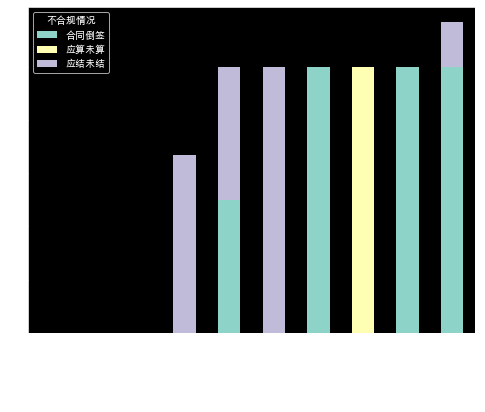

In [18]:
plt_analysis = df_analysis_by_branch.iloc[:, :3].plot.bar(figsize=(8, 6), stacked=True, rot=45)
plt_analysis.get_figure().savefig(out_dir / f'{path_file.stem}.png', dpi=800, bbox_inches='tight')
plt_analysis